In [13]:
import saflow
from saflow.features.utils import create_fnames, segment_sourcelevel
import mne
from mne_bids import read_raw_bids
import mne_bids
import numpy as np

In [2]:
subject = '19'
run = '02'

filepaths = create_fnames('19', '02')
filepaths['raw']

BIDSPath(
root: /media/hyruuk/YH_storage/DATA/saflow/bids
datatype: meg
basename: sub-19_task-gradCPT_run-02_meg)

In [3]:
raw = read_raw_bids(filepaths['raw'])

ds directory : /media/hyruuk/YH_storage/DATA/saflow/bids/sub-19/meg/sub-19_task-gradCPT_run-02_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.


    Quaternion matching (desired vs. transformed):
      -0.88   70.05    0.00 mm <->   -0.88   70.05    0.00 mm (orig :  -55.63   42.68 -261.91 mm) diff =    0.000 mm
       0.88  -70.05    0.00 mm <->    0.88  -70.05    0.00 mm (orig :   42.63  -57.12 -257.81 mm) diff =    0.000 mm
      93.09    0.00    0.00 mm <->   93.09   -0.00   -0.00 mm (orig :   60.42   56.58 -270.71 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    Measurement info composed.
Finding samples for /media/hyruuk/YH_storage/DATA/saflow/bids/sub-19/meg/sub-19_task-gradCPT_run-02_meg.ds/sub-19_task-gradCPT_run-02_meg.meg4: 
    System clock channel is available, checking which samples are valid.
    1 x 588000 = 588000 samples from 334 chs
Current compensation grade : 3
Reading events from /media/hyruuk/YH_storage/DATA/saflow/bids/sub-19/meg/sub-19_task-gradCPT_run-02_events.tsv.
Reading channel info fr

/tmp/ipykernel_269234/860043212.py:1: RuntimeWarning: The unit for channel(s) HADC001-3105, HADC002-3105, HADC003-3105, HDAC001-3105, HDAC002-3105, HDAC003-3105, HLC0011-2104, HLC0012-2104, HLC0013-2104, HLC0014-2104, HLC0015-2104, HLC0016-2104, HLC0017-2104, HLC0018-2104, HLC0021-2104, HLC0022-2104, HLC0023-2104, HLC0024-2104, HLC0025-2104, HLC0026-2104, HLC0027-2104, HLC0028-2104, HLC0031-2104, HLC0032-2104, HLC0033-2104, HLC0034-2104, HLC0035-2104, HLC0036-2104, HLC0037-2104, HLC0038-2104, SCLK01-177 has changed from V to NA.
  raw = read_raw_bids(filepaths['raw'])


In [4]:
raw = mne_bids.read_raw_bids(filepaths['preproc'])
data = raw.get_data()
sfreq = raw.info['sfreq']
meg_picks = mne.pick_types(raw.info, meg=True, ref_meg=False, eeg=False, eog=False)
data = data[meg_picks,:]
n_trials=8
n_jobs=-1

segmented_array, events_idx, events_dicts = segment_sourcelevel(data, filepaths, sfreq=sfreq, n_events_window=n_trials)

welch_array = mne.time_frequency.psd_array_welch(segmented_array, sfreq=sfreq, n_jobs=n_jobs, n_fft=1022, n_overlap=959, average='median')


Opening raw data file /media/hyruuk/YH_storage/DATA/saflow/bids/derivatives/preprocessed/sub-19/meg/sub-19_task-gradCPT_run-02_proc-clean_meg.fif...
    Read 5 compensation matrices
    Range : 0 ... 587999 =      0.000 ...   489.999 secs
Ready.
Current compensation grade : 3
Reading events from /media/hyruuk/YH_storage/DATA/saflow/bids/derivatives/preprocessed/sub-19/meg/sub-19_task-gradCPT_run-02_proc-clean_events.tsv.
Reading channel info from /media/hyruuk/YH_storage/DATA/saflow/bids/derivatives/preprocessed/sub-19/meg/sub-19_task-gradCPT_run-02_proc-clean_channels.tsv.
Cannot verify that the cHPI frequencies from the MEG JSON sidecar file correspond to the raw data.
Not fully anonymizing info - keeping his_id, sex, and hand info
Effective window size : 0.852 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:  6.7min remaining: 11.2min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:  6.9min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  7.1min finished


In [34]:
welch_array[0].shape

(555, 270, 512)

/tmp/ipykernel_269234/206649746.py:19: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,120)


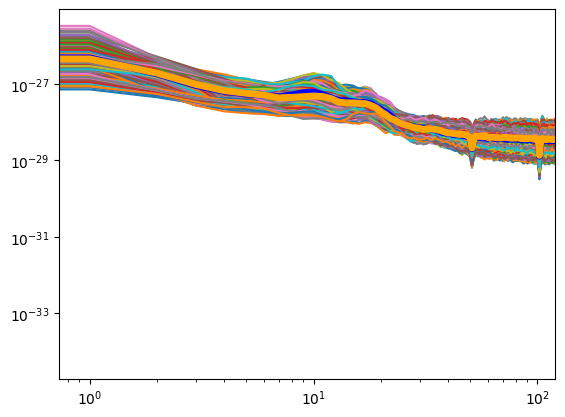

In [39]:
IN_trials = []
OUT_trials = []
for epoch_idx in range(welch_array[0].shape[0]):
    if events_dicts[epoch_idx]['INOUT_2575'] == 'IN':
        IN_trials.append(welch_array[0][epoch_idx,:,:])
    elif events_dicts[epoch_idx]['INOUT_2575'] == 'OUT':
        OUT_trials.append(welch_array[0][epoch_idx,:,:])

IN_average = np.mean(IN_trials, axis=0)
OUT_average = np.mean(OUT_trials, axis=0)

import matplotlib.pyplot as plt


for x in range (IN_average.shape[0]):
    # Same but stop x axis at 120Hz
    plt.loglog(IN_average[x,:])
    plt.loglog(OUT_average[x,:])
    plt.xlim(0,120)

plt.loglog(np.mean(IN_average, axis=0), linewidth=5, color='blue')
plt.loglog(np.mean(OUT_average, axis=0), linewidth=5, color='orange')
plt.show()
    #plt.title('Channel ' + str(x))


In [43]:
IN_average.shape

(270, 512)

Running FOOOFGroup across 270 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.17
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:49: RuntimeWarning: invalid value encountered in scalar divide
  t2 = c / q
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize

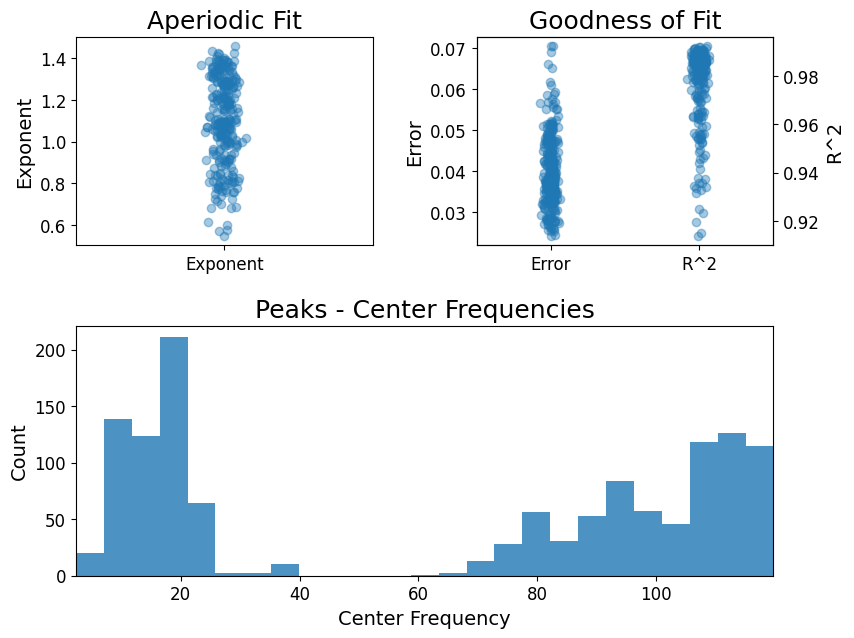

In [46]:
from fooof import FOOOFGroup
# Define `peak_width_limit` setting
peak_width = [1, 8]
# Define `max_n_peaks` setting
n_peaks = 4
# Define `min_peak_height` setting
peak_height = 0.10
# Define frequency range
PSD_range = [2, 120]
# Initialize a model object for spectral parameterization, with some settings 
fg = FOOOFGroup(aperiodic_mode='fixed')#peak_width_limits=peak_width, max_n_peaks=n_peaks, min_peak_height=peak_height, verbose=False, aperiodic_mode='fixed')

fg.fit(welch_array[1], IN_average, PSD_range)
fg.plot()

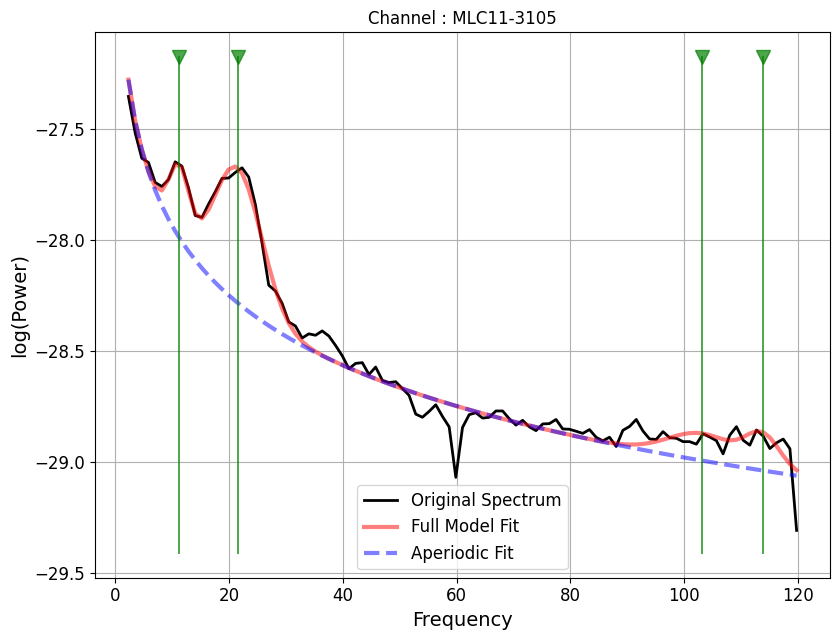

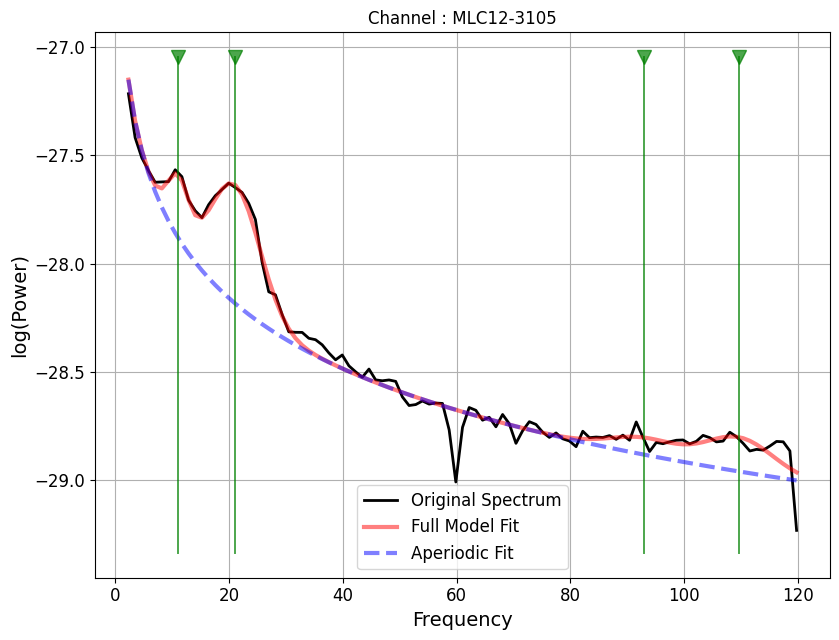

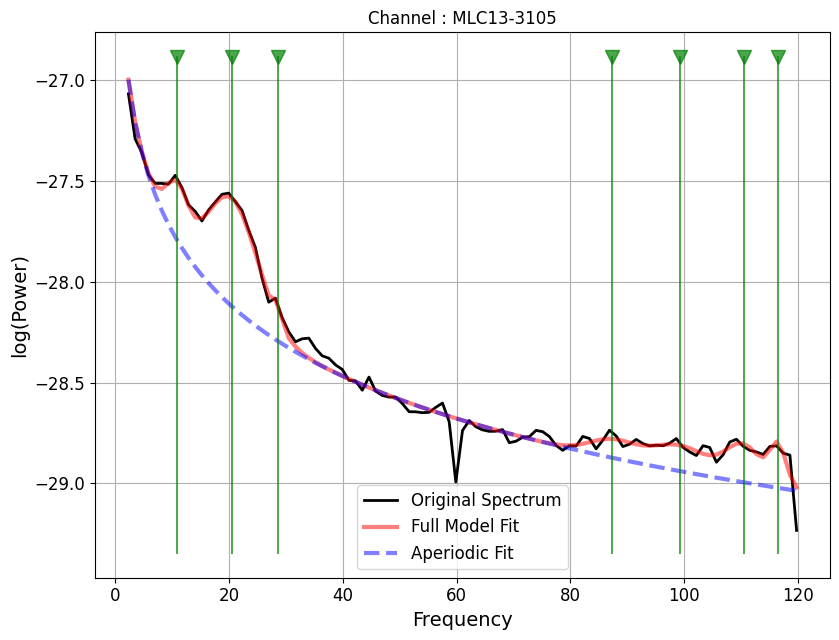

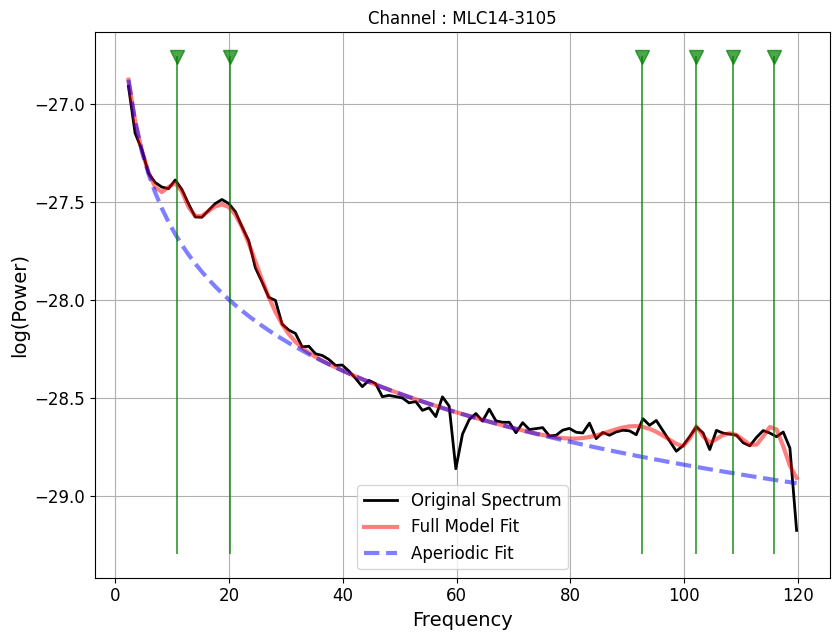

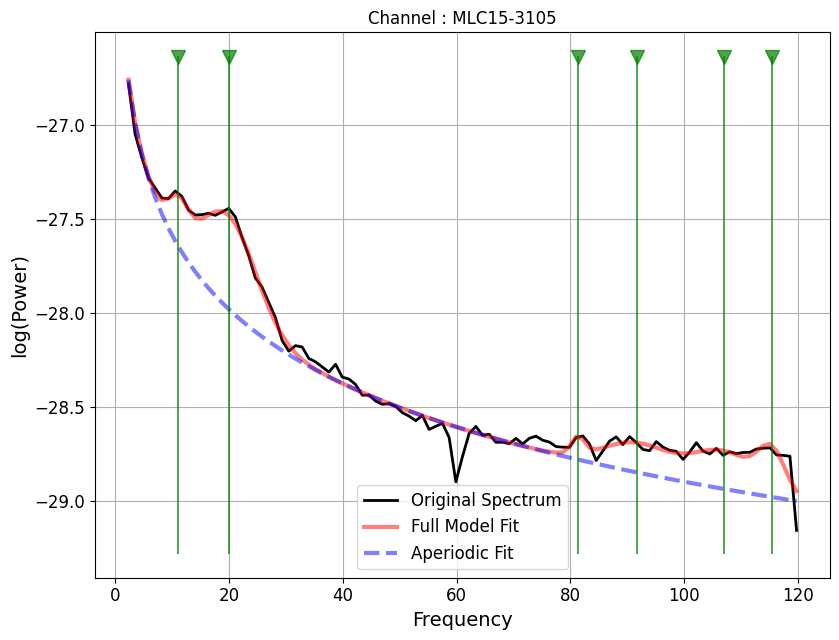

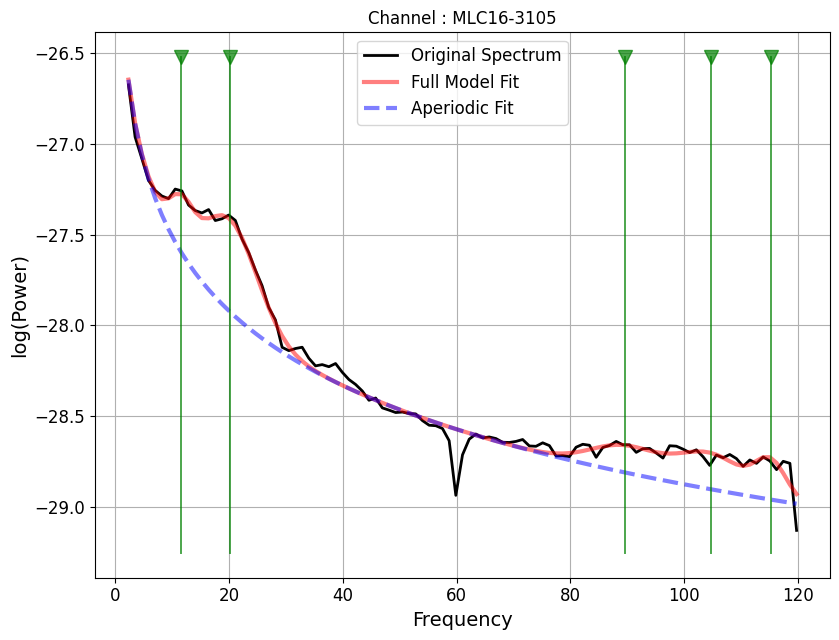

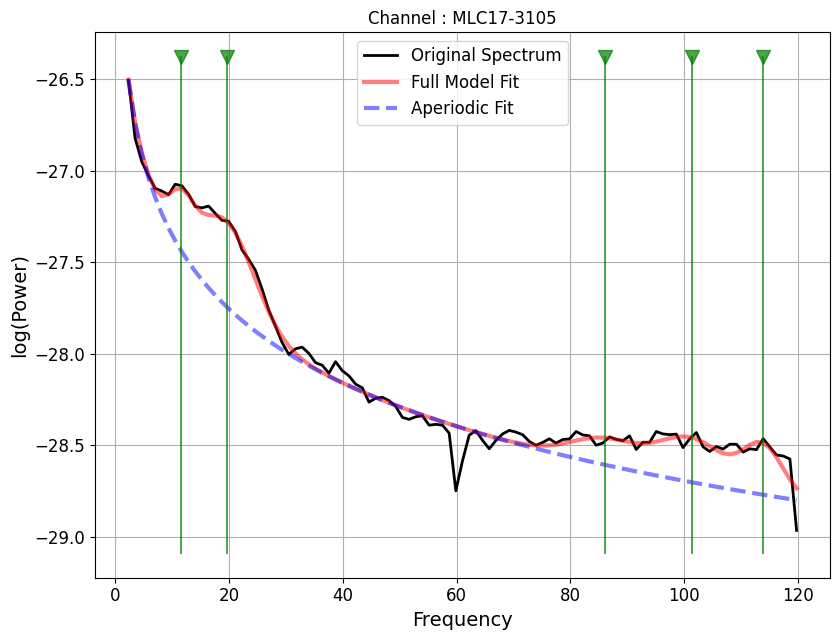

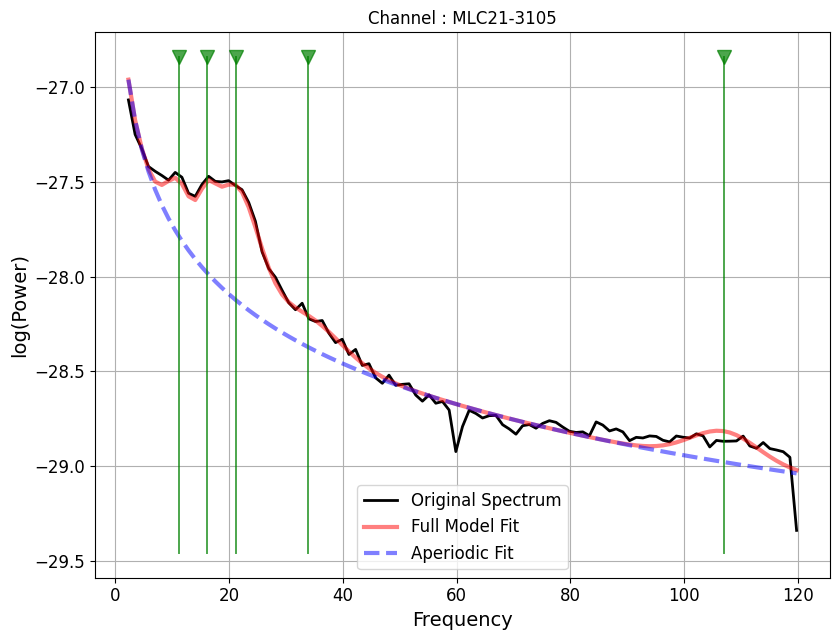

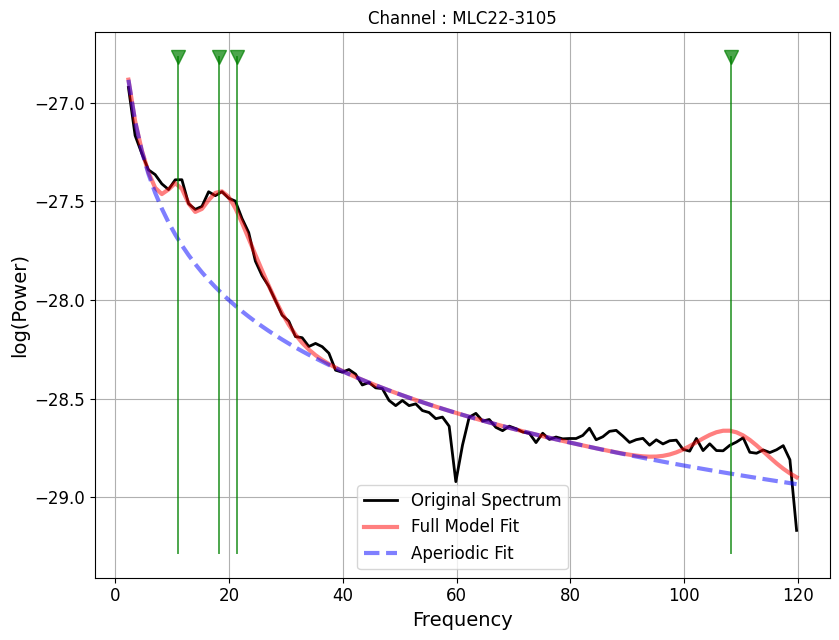

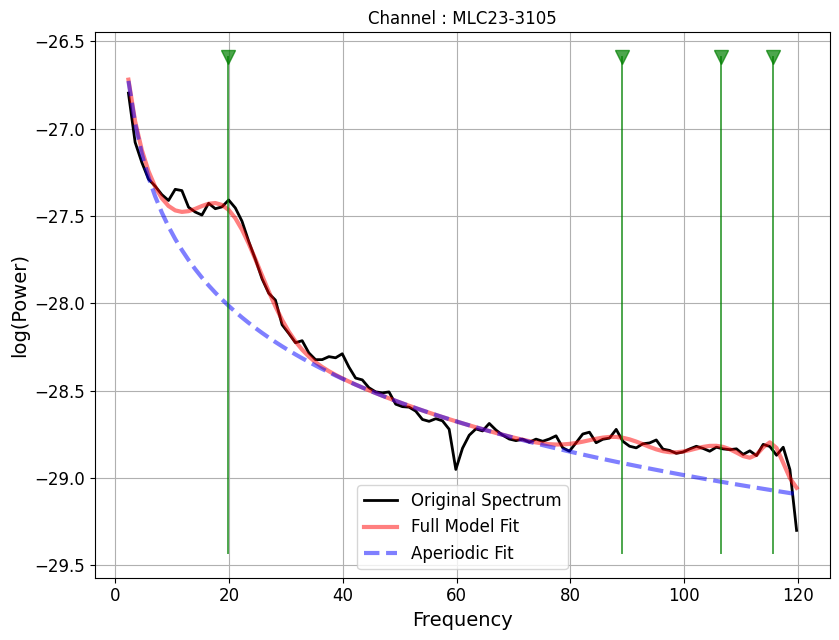

In [50]:
for i in range(10):
    fg.get_fooof(i).plot(plot_peaks='line')
    ch_name = raw.info['ch_names'][meg_picks[i]]
    plt.title(f'Channel : {ch_name}')

In [49]:
raw.info['ch_names'][meg_picks[i]]

'MLC23-3105'